In [1]:
#%%
#%% 
import os
import numpy as np
import pandas as pd
from glob import glob
from openslide import open_slide
from scipy.io import loadmat
from skimage.measure import label, regionprops
import pickle 
from tqdm import tqdm
from tqdm import tqdm
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle
import matplotlib.colors as mcolors
from skimage.measure import regionprops

In [2]:
#%%
file = "Xenium_Prime_Human_Lung_Cancer_FFPE_he_image_coregistered_pyramid.ome.tif"
aitil_path = "/rsrch5/home/plm/phacosta/aitil_t6/output_pa2"
slide_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Xenium_Prime_Human_Lung_Cancer_FFPE_outs/{file}"



In [25]:
#%%%
file_name = os.path.basename(slide_path)
wsi_file = slide_path
slide = open_slide(wsi_file)

mat_dir = f"{aitil_path}/3_cell_seg/mat/{file_name}"
csv_dir = f"{aitil_path}/4_cell_class/csv/{file_name}"

# Load cell position data
cellpos_file = f"{aitil_path}/4_cell_class/CellPos/{file_name}_cellPos.csv"
cellPos_df = pd.read_csv(cellpos_file)
cellPos_df[['x_scaled', 'y_scaled']] = cellPos_df[['x', 'y']].apply(lambda col: col * 16)

class_dict = {'o': 1, 'f': 2, 't': 3, 'l': 4}

# Create a DataFrame of unique tile coordinates
tile_coords_df = cellPos_df[['tile_file', 'tile_x', 'tile_y']].drop_duplicates()

# Load rescale factor
param_file = f"{aitil_path}/1_cws_tiling/{file_name}/param.p"
with open(param_file, "rb") as f:
    params = pickle.load(f)
rescale_factor = params['rescale']

# Initialize the downsampled whole slide images
wsi_ds = np.zeros((int(slide.dimensions[1] / rescale_factor), int(slide.dimensions[0] / rescale_factor)), dtype=np.uint32)
wsi_ds_class = np.zeros_like(wsi_ds, dtype=np.uint8)  # For class values

# Initialize label counter
label_counter = 1  # Start labeling from 1

In [88]:
# Process each tile
for _, row in tile_coords_df.iterrows():
# _, row = next(tile_coords_df.iterrows())
    print(f"\nProcessing {row['tile_file']}")
    mat_file_path = os.path.join(mat_dir, row['tile_file'].replace(".csv", ".mat"))
    csv_file_path = os.path.join(csv_dir, row['tile_file'])
    mat_data = loadmat(mat_file_path)
    csv_data = pd.read_csv(csv_file_path)

    cell_seg_mask = mat_data['mat'][0][0][1]

    # Label the cell segmentation mask
    cell_ids = label(cell_seg_mask)

    # Extract contours (regions) of the labeled cells
    regions = regionprops(cell_ids)

    # Initialize class mask for this tile
    cell_classes = np.zeros_like(cell_ids, dtype=np.uint8)

    print("CSV Data:", csv_data.shape[0])
    print("Cell IDs", np.unique(cell_ids).shape[0]-1)

    matched = 0
    unmatched_points = [row for row in csv_data[["V2","V3"]].values]
    matched_regions = []
    # Iterate through each point in the CSV
    for _, point in csv_data.iterrows():
        x_point, y_point = int(point['V2']), int(point['V3'])  # Coordinates from the CSV
        cell_class = class_dict.get(point['V1'], 0)  # Class value from the CSV
        coordinate_to_remove = np.array([x_point, y_point])
        
        # Check if the point is inside any region
        for c, region in enumerate(regions):
            if (y_point, x_point) in region.coords:
                matched += 1
                unmatched_points = [arr for arr in unmatched_points if not np.array_equal(arr, coordinate_to_remove)]
                matched_regions.append(c)
                # Assign the class to all pixels in this region
                cell_classes[cell_ids == region.label] = cell_class
                break
        

    print(f"Matched points: {matched} / {len(csv_data)}")

    if matched!=len(csv_data):
        print(f"Cells were not all matched: {row['tile_file']}")
        print(unmatched_points)
        break

    # Map the tile-specific masks into the global masks
    y_start, x_start = row['tile_y'], row['tile_x']
    y_end = y_start + cell_seg_mask.shape[0]
    x_end = x_start + cell_seg_mask.shape[1]

    # Ensure the tile fits within the global mask
    if y_end > wsi_ds.shape[0] or x_end > wsi_ds.shape[1]:
        y_end = min(y_end, wsi_ds.shape[0])
        x_end = min(x_end, wsi_ds.shape[1])
        cell_ids = cell_ids[: y_end - y_start, : x_end - x_start]
        cell_classes = cell_classes[: y_end - y_start, : x_end - x_start]

    # Update the global masks
    wsi_ds[y_start:y_end, x_start:x_end] = np.where(cell_ids > 0, cell_ids + label_counter, 0)
    wsi_ds_class[y_start:y_end, x_start:x_end] = cell_classes

    # Update label counter
    label_counter += cell_ids.max()


Processing Da11.csv
CSV Data: 292
Cell IDs 292
Matched points: 292 / 292

Processing Da12.csv
CSV Data: 811
Cell IDs 811
Matched points: 811 / 811

Processing Da13.csv
CSV Data: 239
Cell IDs 239
Matched points: 238 / 239
Cells were not all matched: Da13.csv
[array([1993, 1288])]


In [3]:
# Upsample to original dimensions
wsi_fullres_obj = resize(
    wsi_ds, 
    (slide.dimensions[1], slide.dimensions[0]), 
    order=0, preserve_range=True, anti_aliasing=False
).astype(np.uint32)

wsi_fullres_class = resize(
    wsi_ds_class, 
    (slide.dimensions[1], slide.dimensions[0]), 
    order=0, preserve_range=True, anti_aliasing=False
).astype(np.uint8)

Point is outside all bounding boxes.
239
[237, 232, 157, 167, 231, 232, 231, 182, 221, 153, 128, 108, 223, 217, 167, 157, 197, 217, 217, 162, 218, 214, 214, 134, 143, 202, 202, 189, 202, 202, 101, 114, 55, 120, 191, 201, 201, 102, 120, 162, 119, 157, 109, 180, 87, 189, 87, 189, 3, 189, 166, 103, 180, 45, 69, 134, 180, 154, 155, 119, 101, 145, 55, 167, 109, 167, 20, 163, 97, 160, 163, 163, 163, 161, 161, 1, 161, 16, 160, 159, 46, 154, 154, 129, 154, 113, 152, 139, 139, 89, 121, 139, 139, 139, 139, 139, 139, 132, 111, 96, 59, 127, 121, 34, 132, 132, 132, 127, 47, 127, 127, 7, 123, 120, 111, 11, 115, 115, 108, 115, 81, 115, 24, 84, 114, 102, 11, 111, 40, 108, 108, 3, 78, 84, 56, 99, 98, 99, 18, 27, 3, 92, 11, 78, 81, 89, 4, 42, 89, 70, 83, 83, 66, 42, 83, 76, 7, 81, 42, 66, 78, 54, 70, 75, 54, 47, 18, 43, 3, 19, 46, 56, 64, 40, 55, 63, 56, 47, 44, 48, 8, 44, 56, 55, 51, 49, 21, 44, 47, 47, 35, 47, 45, 43, 42, 27, 41, 26, 40, 16, 37, 37, 7, 21, 34, 28, 30, 10, 30, 25, 25, 23, 25, 25, 24, 2

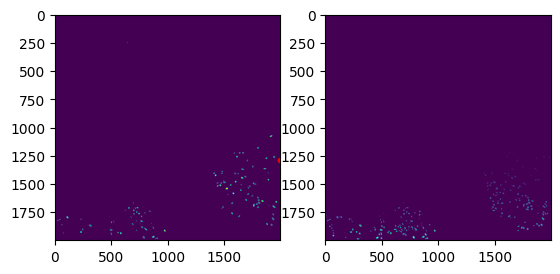

In [91]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cell_classes)
plt.scatter(unmatched_points[0][0], unmatched_points[0][1],s=10, c="r")
plt.subplot(1,2,2)
plt.imshow(cell_ids)

x_point, y_point = 1993, 1288
found = False
for region in regions:
    minr, minc, maxr, maxc = region.bbox
    if minr <= y_point < maxr and minc <= x_point < maxc:
        print(f"Point is in bounding box of Region {region.label}")
        found = True
        break
if not found:
    print("Point is outside all bounding boxes.")
    
print(len(regions))
print(matched_regions)

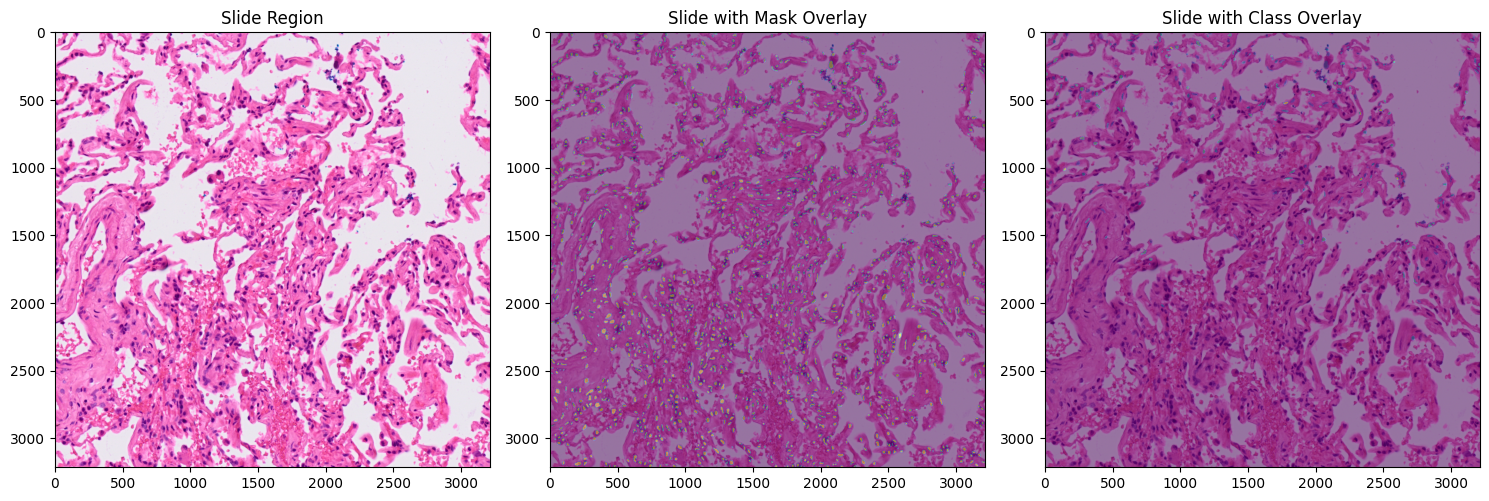

In [18]:
    
#%%

test_tile = "Da30.csv"

# Define the starting point for the 1000x1000 window
x_start, y_start =  np.uint32(cellPos_df[cellPos_df.tile_file == test_tile][["tile_x", "tile_y"]].iloc[0].values * rescale_factor)

rescaled_size = int(2000*rescale_factor)

# Extract the 1000x1000 region from the slide at the original resolution
slide_region = slide.read_region((x_start, y_start), 0, (rescaled_size, rescaled_size)).convert("RGB")

#% Extract the corresponding region from the stitched mask (already upscaled to match the slide dimensions)
mask_region = wsi_fullres_obj[y_start:y_start + rescaled_size, x_start:x_start + rescaled_size]

class_region = wsi_fullres_class[y_start:y_start + rescaled_size, x_start:x_start + rescaled_size]

# Plot the slide region and mask overlay for sanity check
plt.figure(figsize=(15,10))

# Show the slide region
plt.subplot(1, 3, 1)
plt.imshow(slide_region)
plt.title("Slide Region")

# Show the corresponding mask region overlayed on the slide region
plt.subplot(1, 3, 2)
plt.imshow(slide_region)
plt.imshow(mask_region, alpha=0.5, cmap="viridis")  # Overlay mask with transparency
plt.title("Slide with Mask Overlay")

# Define a custom colormap with 5 colors from tab10
# cmap = mcolors.ListedColormap(plt.cm.tab10.colors[:np.unique(class_region).size])  # Use the first 5 colors
# norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 5.5, 1), ncolors=5)  # Define boundaries for discrete values

# Show the corresponding class region overlayed on the slide region
plt.subplot(1, 3, 3)
im = plt.imshow(slide_region)
plt.imshow(class_region, alpha=0.5)  # Use custom colormap and normalization
plt.title("Slide with Class Overlay")
# cbar = plt.colorbar( ticks=np.arange(0, 5))  # Add a colorbar with ticks for 0–4
# cbar.set_label("Class Labels")  # Label the colorbar

plt.tight_layout()
plt.show()


#%%
class_mat_dir = "/rsrch5/home/plm/phacosta/aitil_t6/output_pa2/4_cell_class/mat/Xenium_Prime_Human_Lung_Cancer_FFPE_he_image_coregistered_pyramid.ome.tif"
class_mats = glob(os.path.join(class_mat_dir, "*.mat"))

# %%

In [19]:
print("Unique labels in wsi_full_res:", np.unique(wsi_fullres_obj))
print("Unique classes in wsi_fullres_class:", np.unique(wsi_fullres_class))


Unique labels in wsi_full_res: [     0      2      3 ... 299836 299837 299838]
Unique classes in wsi_fullres_class: [0 1 2 3 4]
